My plan is to create a bot that parses the 10 last major news articles of a given keyword in order to generate a summary of each article in a few seconds followed by a sentiment analysis.

This is informative and useful to anyone as a trader/investor when considering recent stocks or crypto news!

You can also use it for fun or out of curiosity for any given keyword of your interest!

The flow of the bot:
1_Extract => 2_Summarize => 3_Analyze => 4_Generate graphs about sentiment & polarity

1_We extract the articles from Google news with the Google News python package.

2_We summarize each article using Newspaper Python Package

3_Run sentiment analysis on each summary with the help of VADER.

4_Generate a 24H sentiment graph & polarity scatterplot.

In [34]:
#Uncomment the lines below to install the required packages:

# !pip install GoogleNews
# !pip install nltk
# !pip install newspaper3k
# !pip install wordcloud

In [35]:
#Importing Libraries

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from textblob import TextBlob

import nltk
plt.style.use('seaborn-whitegrid')
%matplotlib inline

#Required for Sentiment Analysis
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Loading analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Fluffy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


News Extraction.

In [36]:
#Defining the dates to be used in the GoogleNews Query in next cell
now = dt.date.today()
now = now.strftime('%m-%d-%Y')

yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'

config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fluffy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Keep in mind that the Google News package fetches only the 10 most recent news, we will bypass this with a loop in order to extract all possible articles in the first 10 pages in Google News, it will gather between 30 to 70 articles on average.

In [37]:
keyword_interest = input("Please provide the name of the asset, stock or crypto of interest")
if keyword_interest != '':
    print(f'Extracting & Analyzing {keyword_interest}, it takes sometime!')
googlenews = GoogleNews(start = yesterday, end = now )
googlenews.search(keyword_interest)
googlenews.total_count()

result = googlenews.result()

#This loop is to bypass the limit of 10 articles
for i in range(2,8):
    googlenews.getpage(i)
    result=googlenews.result()
    df=pd.DataFrame(result)

#Storing Results in a pd DataFrame
list=[]
df = pd.DataFrame(result)
print(df)

Extracting & Analyzing snapchat, it takes sometime!
                                                title                   media  \
0   Snapchat's revenue warning ripples throughout ...               eMarketer   
1   Meta Platforms Stock: Ignore The Snapchat Doom...           Seeking Alpha   
2   Snapchat Just Fell 40%, Dragging Other Social ...               The Quint   
3   Pixy drone hands-on: A flying robot photograph...                Engadget   
4   Illinois Snapchat lawsuit: Residents accuse ap...  Rockford Register Star   
..                                                ...                     ...   
65  Young Adults are Turning to Social Media to Bu...            Legal Reader   
66  Social Advertising & Social Media Marketing Ma...          The Daily Vale   
67  Europe Stocks Bounce After Dipping on Recessio...    Investing.com Canada   
68  Valley schools on high alert following deadly ...                    KRGV   
69  Kylie Jenner's Hilarious Filter Video of Kenda...    

Article Summarizing, be patient could take more than 2 minutes to run!!!

In [38]:
try:
    list = []
    for i in df.index:
        #Empty dictionary to append each article in each iteration
        dict = {}
        article = Article(df['link'][i], config = config)
        try:
            article.download()
            article.parse()
            article.nlp()
        except:
            pass
        dict['Date'] = df['date'][i]
        dict['Media'] = df['media'][i]
        dict['Title'] = article.title
        dict['Article'] = article.text
        dict['Summary'] = article.summary
        dict['Key_words'] = article.keywords

        dict['datetime'] = df['datetime'][i]
        
        list.append(dict)
    check_empty = not any(list)

    if check_empty == False:
        news_DF = pd.DataFrame(list)
        print(news_DF)

except Exception as e:
    print("There is an exception:"+ str(e))
    print("There are some issues in retrieving the date. Try again or enter a different keyword of interest!")

c:\Users\Fluffy\AppData\Local\Programs\PythonCodingPack\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


           Date                   Media  \
0     1 day ago               eMarketer   
1   1 hours ago           Seeking Alpha   
2     1 day ago               The Quint   
3     1 day ago                Engadget   
4     1 day ago  Rockford Register Star   
..          ...                     ...   
65   1 hour ago            Legal Reader   
66  9 hours ago          The Daily Vale   
67    1 day ago    Investing.com Canada   
68  8 hours ago                    KRGV   
69  7 hours ago                Newsweek   

                                                Title  \
0   Snapchat’s revenue warning ripples throughout ...   
1   Meta Platforms Stock: Ignore The Snapchat Doom...   
2   Snapchat Just Fell 40%, Dragging Other Social ...   
3   Pixy drone hands-on: A flying robot photograph...   
4   Illinois residents bring class-action lawsuit ...   
..                                                ...   
65  Young Adults are Turning to Social Media to Bu...   
66  Social Advertising & So

In [39]:
#Change Columns order
news_DF = news_DF[['datetime', 'Media', 'Title', 'Article', 'Summary', 'Date', 'Key_words']]

#Taking a look at our dataframe so far
news_DF.head()


,datetime,Media,Title,Article,Summary,Date,Key_words
0,2022-05-25 11:24:41.728806,eMarketer,Snapchat’s revenue warning ripples throughout ...,The news: Snapchat owner Snap Inc. issued a wa...,The news: Snapchat owner Snap Inc. issued a wa...,1 day ago,"[advertising, spending, snap, revenue, tech, m..."
1,2022-05-26 10:24:41.734791,Seeking Alpha,Meta Platforms Stock: Ignore The Snapchat Doom...,Victollio/iStock Editorial via Getty Images\n\...,The company warned that its Q2 revenue and EBI...,1 hours ago,"[ignore, platforms, snap, revenue, q2, fb, ear..."
2,2022-05-25 11:24:41.750812,The Quint,"Snapchat Just Fell 40%, Dragging Other Social ...","The share price of Snap Inc, the company behin...","The share price of Snap Inc, the company behin...",1 day ago,"[snap, twitter, media, stocks, social, fell, 4..."
3,2022-05-25 11:24:41.768754,Engadget,Pixy drone hands-on: A flying robot photograph...,"Drones are everywhere these days, filming dram...","Last month, Snap debuted the $230 Pixy drone e...",1 day ago,"[robot, drone, snap, photographer, video, pixy..."
4,2022-05-25 11:24:41.783916,Rockford Register Star,Illinois residents bring class-action lawsuit ...,Social media app Snapchat is being accused of ...,Social media app Snapchat is being accused of ...,1 day ago,"[information, bipa, lawsuit, classaction, face..."


In [40]:
vader = SentimentIntensityAnalyzer()

#Columns Date, Media Title Article Summary Key_words
#Iterating through the summary to generate polarity sores with Vader
scores = news_DF['Title'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)

news_DF = news_DF.join(scores_df, rsuffix='right')

news_DF.head()


,datetime,Media,Title,Article,Summary,Date,Key_words,neg,neu,pos,compound
0,2022-05-25 11:24:41.728806,eMarketer,Snapchat’s revenue warning ripples throughout ...,The news: Snapchat owner Snap Inc. issued a wa...,The news: Snapchat owner Snap Inc. issued a wa...,1 day ago,"[advertising, spending, snap, revenue, tech, m...",0.286,0.714,0.0,-0.3400
1,2022-05-26 10:24:41.734791,Seeking Alpha,Meta Platforms Stock: Ignore The Snapchat Doom...,Victollio/iStock Editorial via Getty Images\n\...,The company warned that its Q2 revenue and EBI...,1 hours ago,"[ignore, platforms, snap, revenue, q2, fb, ear...",0.557,0.443,0.0,-0.8316
2,2022-05-25 11:24:41.750812,The Quint,"Snapchat Just Fell 40%, Dragging Other Social ...","The share price of Snap Inc, the company behin...","The share price of Snap Inc, the company behin...",1 day ago,"[snap, twitter, media, stocks, social, fell, 4...",0.000,1.000,0.0,0.0000
3,2022-05-25 11:24:41.768754,Engadget,Pixy drone hands-on: A flying robot photograph...,"Drones are everywhere these days, filming dram...","Last month, Snap debuted the $230 Pixy drone e...",1 day ago,"[robot, drone, snap, photographer, video, pixy...",0.000,1.000,0.0,0.0000
4,2022-05-25 11:24:41.783916,Rockford Register Star,Illinois residents bring class-action lawsuit ...,Social media app Snapchat is being accused of ...,Social media app Snapchat is being accused of ...,1 day ago,"[information, bipa, lawsuit, classaction, face...",0.192,0.808,0.0,-0.2263


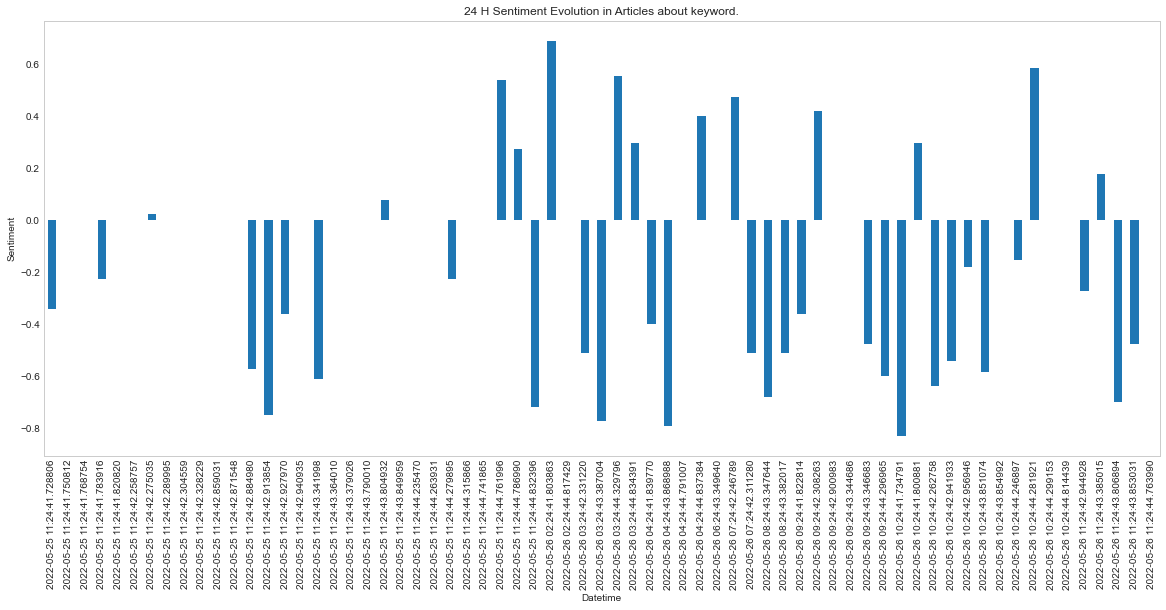

In [41]:
from pandas import tseries

plt.rcParams['figure.figsize'] = [20, 8]
mean_scores = news_DF.groupby(['datetime']).mean()

mean_scores = mean_scores.unstack()

mean_scores = mean_scores.xs('compound').transpose()
mean_scores.plot(kind = 'bar')
plt.xlabel('Datetime')
plt.ylabel('Sentiment')
plt.title('24 H Sentiment Evolution in Articles about keyword.')

plt.grid()

Subjectivity

In [42]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create 2 columns
news_DF['Subjectivity'] = news_DF['Summary'].apply(getSubjectivity)
news_DF['Polarity'] = news_DF['Summary'].apply(getPolarity)
news_DF.drop(['Key_words', 'Media'], axis=1, inplace= True)

#Preview the DF with Subjectivity &  Polarity columns
news_DF.head(3)

,datetime,Title,Article,Summary,Date,neg,neu,pos,compound,Subjectivity,Polarity
0,2022-05-25 11:24:41.728806,Snapchat’s revenue warning ripples throughout ...,The news: Snapchat owner Snap Inc. issued a wa...,The news: Snapchat owner Snap Inc. issued a wa...,1 day ago,0.286,0.714,0.0,-0.3400,0.245175,-0.037281
1,2022-05-26 10:24:41.734791,Meta Platforms Stock: Ignore The Snapchat Doom...,Victollio/iStock Editorial via Getty Images\n\...,The company warned that its Q2 revenue and EBI...,1 hours ago,0.557,0.443,0.0,-0.8316,0.458120,0.155983
2,2022-05-25 11:24:41.750812,"Snapchat Just Fell 40%, Dragging Other Social ...","The share price of Snap Inc, the company behin...","The share price of Snap Inc, the company behin...",1 day ago,0.000,1.000,0.0,0.0000,0.306818,-0.078030


Computing Negative, Neutral & Positive Analysis

In [43]:
 def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0 :
        return 'Neutral'
    else:
        return 'Positive'

#Adding Analysis column to our DF
news_DF['Analysis'] = news_DF['Polarity'].apply(getAnalysis)
news_DF.head(3)

,datetime,Title,Article,Summary,Date,neg,neu,pos,compound,Subjectivity,Polarity,Analysis
0,2022-05-25 11:24:41.728806,Snapchat’s revenue warning ripples throughout ...,The news: Snapchat owner Snap Inc. issued a wa...,The news: Snapchat owner Snap Inc. issued a wa...,1 day ago,0.286,0.714,0.0,-0.3400,0.245175,-0.037281,Negative
1,2022-05-26 10:24:41.734791,Meta Platforms Stock: Ignore The Snapchat Doom...,Victollio/iStock Editorial via Getty Images\n\...,The company warned that its Q2 revenue and EBI...,1 hours ago,0.557,0.443,0.0,-0.8316,0.458120,0.155983,Positive
2,2022-05-25 11:24:41.750812,"Snapchat Just Fell 40%, Dragging Other Social ...","The share price of Snap Inc, the company behin...","The share price of Snap Inc, the company behin...",1 day ago,0.000,1.000,0.0,0.0000,0.306818,-0.078030,Negative


Plotting the Polarity & Subjectivity:
    When dots show big horizontal spread => there are big differences of opinion about the keyword of interest.
    When dots are clustered near 0.0 horizontally => same ideas are shared regarding the keyword of interest.

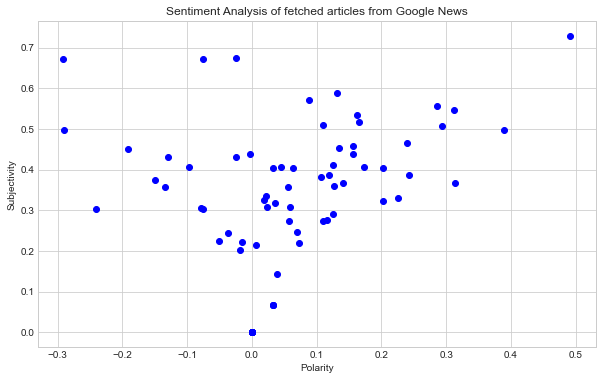

In [44]:
plt.figure(figsize=(10, 6))
for i in range(0, news_DF.shape[0]):
    plt.scatter(news_DF['Polarity'][i], news_DF['Subjectivity'][i], color = 'Blue')

plt.title('Sentiment Analysis of fetched articles from Google News')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

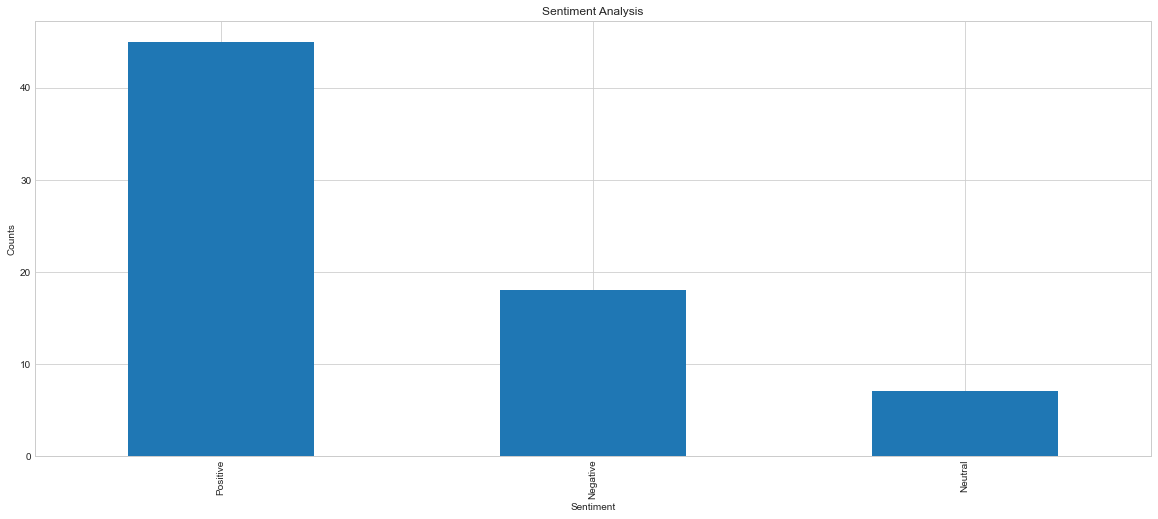

In [45]:
#Value Counts Positive, Negative, Neutral of Articles
news_DF['Analysis'].value_counts()

#Plot & Visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
news_DF['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

WordCloud for snapchat


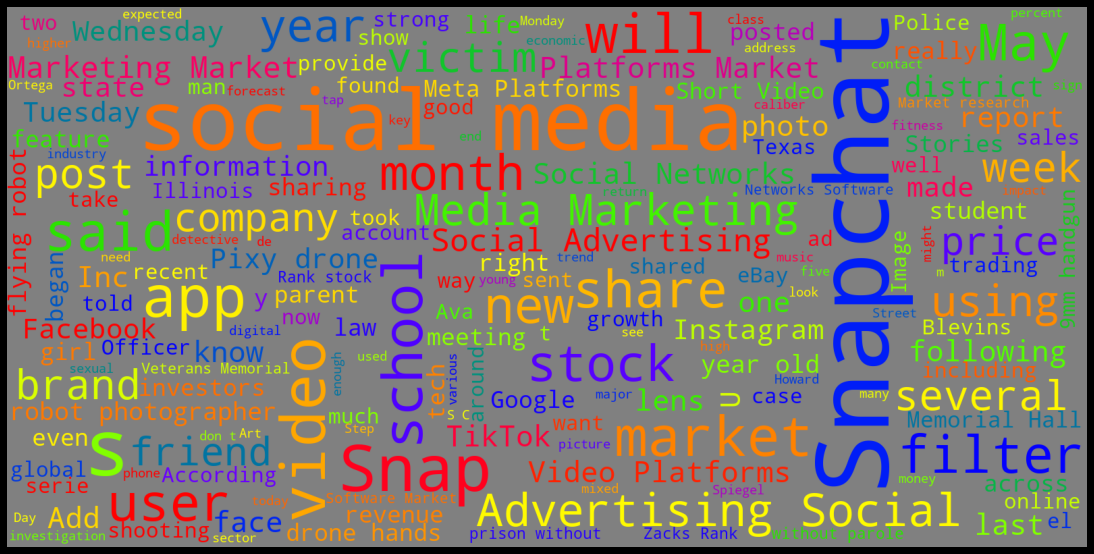

In [46]:
def cloud_words(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color = 'grey', width = 1600, height = 800, stopwords = stopwords, min_font_size= 18, max_font_size= 150, colormap= 'prism').generate(allWords)

    fig, ax = plt.subplots(figsize = (15,10), facecolor = 'k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad = 0)
    plt.show()

print('WordCloud for ' + keyword_interest)
cloud_words(news_DF['Summary'].values)